# Example 01: Full Workflow (Rebit)

## Synopsis

This notebook reproduces our experiment on D-Wave using purely real evolution. The steps presented in this notebook are as follows:

1. Defining the problem.
2. Constructing the QUBO.
3. Solving the QUBO using preferred solver.
4. Interpreting the obtained samples to plot dynamics of example expectation value.

## 1. Defining the problem

In [1]:
import numpy as np
from dwdynamics import RealDynamicsProblem, Objective
# We simulate evolution under the Hamiltonian 1/2 pi * Sigma_y...
SY = np.array([[0, -1.0j], [1.0j, 0.0]])

# The problem object encapsulates all the data so you don't have to pass them around
problem = RealDynamicsProblem(
    hamiltonian=0.5 * np.pi * SY,      # Evolution under hamiltonian 0.5 * np.pi * sigma_y
    initial_state = np.array([1, 0]),  # Starting at initial state |0>
    times=tuple(range(6)),             # With six time points 0,...,5
    num_bits_per_var=2                 # And two bits of precision per variable
)

## 2. Creating QUBO for the problem

In [2]:
qubo = problem.qubo(objective=Objective.norm)  # Other choice would be to use Objective.hessian

hamiltonian.shape=(2, 2)
clock.shape=(12, 12)


In [3]:
# Sanity check 1: total number of QUBO variables is:
# num_vars = dimension of system * number of time points * number of bits per variable
assert qubo.num_variables == problem.hamiltonian.shape[0] * len(problem.times) * problem.num_bits_per_var

## 3a. Solving using Dimod's exact solver
Since system size is small (24 bits), we can use an exact solver to find the ground state.

In [4]:
from dimod import ExactSolver

exact_solver = ExactSolver()

exact_result = exact_solver.sample(qubo)

In [5]:
# Sanity check 2: solution should be exact, and so the energy should be 0
# Note that this is only the case for default, norm-based objective.
# For hessian-based objective the energy might be nonzero.
assert exact_result.first.energy == 0.0

## 3b. Solving using Dimod's Simulated Annealing Sampler

In [6]:
from dimod import SimulatedAnnealingSampler

sa_sampler = SimulatedAnnealingSampler()

sa_result = sa_sampler.sample(qubo, num_reads=50)

sa_result.first.energy

np.float64(1.0)

## 3c. Solving using an actual D-Wave machine

In [7]:
import os
from dwave.system import DWaveSampler, EmbeddingComposite

DW_TOKEN = os.getenv("DW_TOKEN")  # <- Place your token here, or use DW_TOKEN env variable, or configure D-Wave libraries to use config file

# The graph fo the problelm is pretty dense, we use automatic embedding to mitigate the incompatibility with actual machine
dw_sampler = EmbeddingComposite(DWaveSampler(token=DW_TOKEN))

dw_result = dw_sampler.sample(qubo, num_reads=1000, annealing_time=200)

dw_result.first.energy

np.float64(0.0)

## 4. Interpreting the results
As in the original experiment, we use $\langle \sigma_z \rangle$. The exact dynamics will be computed using Qutip.

In [8]:
# Let's compute baseline using QuTiP
import qutip as qp

H_qp = 0.5 * np.pi * qp.sigmay()

psi_0 = qp.basis(2, 0)
times = np.linspace(0, 5, 100)
baseline = qp.mesolve(H_qp, psi_0, times, e_ops=[qp.sigmaz()]).expect[0]

In [9]:
# Define sigma_z for manual computation of expected values
SZ = np.array([[1, 0], [0, -1]])

# decode_sample returns flat vector, we use reshape to form an 6x2 array of states
exact_vec = problem.interpret_sample(exact_result.first.sample)

# For computing the expectation values we just use  s.T * SZ * s, there is no need for complex conjugation because everything is real
exact_expect = [state @ SZ @ state for state in exact_vec]

# SA and D-Wave results get the same treatment
sa_vec = problem.interpret_sample(sa_result.first.sample)
sa_expect = [state @ SZ @ state for state in sa_vec]

dw_vec = problem.interpret_sample(dw_result.first.sample)
dw_expect = [state @ SZ @ state for state in dw_vec]

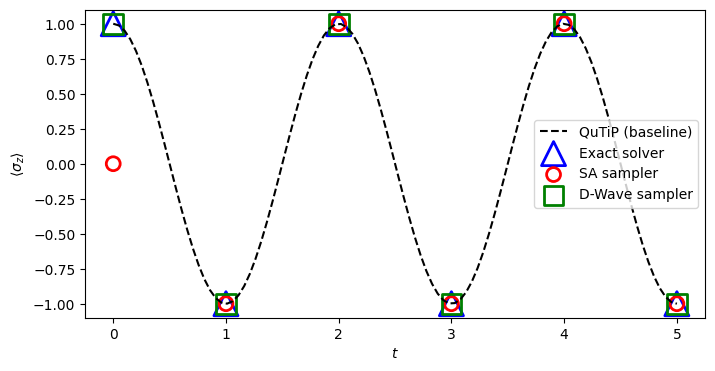

In [10]:
from matplotlib import pyplot as plt

fig, axis = plt.subplots(figsize=(8, 4))

axis.plot(times, baseline, "k--", label="QuTiP (baseline)")

axis.scatter(problem.times, exact_expect, marker="^", lw=2, s=300, edgecolors="b", facecolors="none", label="Exact solver")
axis.scatter(problem.times, sa_expect, marker="o", lw=2, s=100, edgecolors="r", facecolors="none", label="SA sampler")
axis.scatter(problem.times, dw_expect, marker="s", lw=2, s=200, edgecolors="g", facecolors="none", label="D-Wave sampler")

axis.set_ylabel(r"$\langle \sigma_z \rangle$")
axis.set_xlabel("$t$")
axis.legend()